In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [11]:
cancer = load_breast_cancer()
x = cancer.data
y=cancer.target
x_train_all,x_test,y_train_all,y_test = train_test_split(x,y,stratify = y,test_size = 0.2,random_state = 42)
x_train,x_val,y_train,y_val = train_test_split(x_train_all,y_train_all,stratify = y_train_all,test_size = 0.2,random_state = 42)


In [12]:
class SingleLayer:
  def __init__(self,learning_rate = 0.1,l1 = 0, l2 = 0):
    self.w = None
    self.b = None
    #
    self.losses = []
    ##
    self.w_history = []
    ###
    self.val_losses = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2
  def forpass(self,x):
    z = np.dot(x,self.w) + self.b
    return z
  def backprop(self,x,err):
    m = len(x)
    w_grad = np.dot(x.T,err) / m
    b_grad = np.sum(err) /m
    return w_grad,b_grad
  def activation(self,z):
    z = np.clip(z,-100,None)
    a = 1 / (1 + np.exp(-z))
    return a
  def fit(self,x,y,epochs = 100,x_val =None,y_val = None):
    y = y.reshape(-1,1)
    y_val = y_val.reshape(-1,1)
    m = len(x)
    self.w = np.ones((x.shape[1],1))
    self.b = 0
    self.w_history.append(self.w.copy())
    np.random.seed(42)
    for i in range(epochs):  
      z  = self.forpass(x)
      a = self.activation(z)
      err = -(y - a)
      w_grad,b_grad = self.backprop(x,err)
      w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
      self.w -= w_grad * self.lr
      self.b -= b_grad * self.lr
      self.w_history.append(self.w.copy())
      a = np.clip(a,1e-10,1-1e-10)
      loss =  np.sum(-(y*np.log(a)+(1-y)*np.log(1-a)))
      self.losses.append(loss + self.reg_loss() /m)
      self.update_val_loss(x_val,y_val)
  def predict(self,x):
    z = self.forpass(x)
    return z > 0
  def score(self,x,y):
    return np.mean(self.predict(x)==y.reshape(-1,1))
  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
  def update_val_loss(self,x_val,y_val):
    z = self.forpass(x_val)
    a = self.activation(z)
    a = np.clip(a,1e-10,1-1e-10)
    val_loss = np.sum(-(y_val*np.log(a) + (1-y_val) * np.log(1-a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))
  


In [13]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [14]:
single_layer = SingleLayer(l2 = 0.01)
single_layer.fit(x_train_scaled,y_train,x_val = x_val_scaled,y_val = y_val,epochs = 10000)
single_layer.score(x_val_scaled,y_val)


0.978021978021978

In [15]:
single_layer.score(x_val_scaled,y_val)

0.978021978021978

In [16]:
class DualLayer(SingleLayer):
  def __init__(self, units = 10,learning_rate = 0.1,l1 = 0,l2 = 0):
    self.units = units
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2
  def forpass(self,x):
    z1 = np.dot(x,self.w1) + self.b1
    self.a1 = self.activation(z1)
    z2 = np.dot(self.a1,self.w2) + self.b2
    return z2
  def backprop(self,x,err):
    m = len(x)
    w2_grad = np.dot(self.a1.T,err) / m
    b2_grad = np.sum(err) / m
    err_to_hidden = np.dot(err,self.w2.T) * self.a1 * (1-self.a1)
    w1_grad = np.dot(x.T,err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden,axis = 0) / m
    return w1_grad,b1_grad,w2_grad,b2_grad 
  def init_weights(self,n_features):
    self.w1 = np.ones((n_features,self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.ones((self.units,1))
    self.b2 = 0
  def fit(self,x,y,epochs = 100,x_val = None,y_val = None):
    y = y.reshape(-1,1)
    y_val = y_val.reshape(-1,1)
    m = len(x)
    self.init_weights(x.shape[1])
    for i in range(epochs):
      a = self.training(x,y,m)
      a = np.clip(a,1e-10,1-1e-10)
      loss = np.sum(-(y*np.log(a) + (1-y )  *np.log(1-a)))
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val,y_val)
  def training(self,x,y,m):
    z = self.forpass(x)
    a = self.activation(z)
    err = -(y-a)
    w1_grad,b1_grad,w2_grad,b2_grad = self.backprop(x,err)
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    self.w1 -= self.lr * w1_grad
    self.w2 -= self.lr * w2_grad
    self.b1 -= self.lr * b1_grad
    self.b2 -= self.lr * b2_grad
    return a
  def reg_loss(self):
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))


In [17]:
dual_layer = DualLayer(l2 = 0.01)
dual_layer.fit(x_train_scaled,y_train,x_val = x_val_scaled,y_val = y_val,epochs = 20000)


In [18]:
dual_layer.score(x_val_scaled,y_val)

0.978021978021978

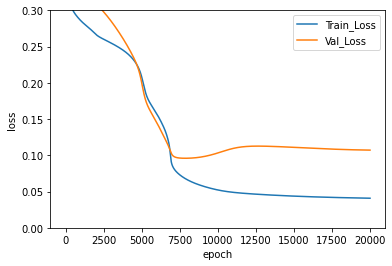

In [19]:
plt.ylim(0,0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["Train_Loss","Val_Loss"])
plt.show()

In [20]:
class RandomInitNetwork(DualLayer):
  def init_weights(self,n_features):
    np.random.seed(42)
    self.w1 = np.random.normal(0,1,(n_features,self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0,1,(self.units,1))
    self.b2 = 0

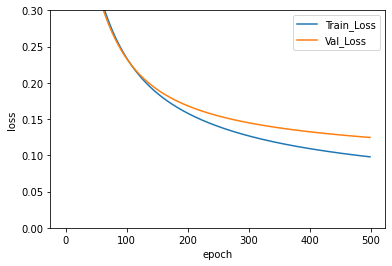

In [21]:
random_init_net = RandomInitNetwork(l2 = 0.01)
random_init_net.fit(x_train_scaled,y_train,x_val = x_val_scaled,y_val = y_val,epochs = 500)

plt.ylim(0,0.3)
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["Train_Loss","Val_Loss"])
plt.show()

In [48]:
class MultiClassNetwork:
  def __init__(self, units = 10,batch_size = 32,learning_rate = 0.1,l1 = 0,l2 = 0):
    self.units = units
    self.batch_size = batch_size
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2
  def forpass(self,x):
    z1 = np.dot(x,self.w1) + self.b1
    self.a1 = self.sigmoid(z1)
    z2 = np.dot(self.a1,self.w2) + self.b2
    return z2
  def backprop(self,x,err):
    m = len(x)
    w2_grad = np.dot(self.a1.T,err) / m
    b2_grad = np.sum(err) / m
    err_to_hidden = np.dot(err,self.w2.T) * self.a1 * (1-self.a1)
    w1_grad = np.dot(x.T,err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden,axis = 0) / m
    return w1_grad,b1_grad,w2_grad,b2_grad 
  def sigmoid(self,z):
    z = np.clip(z,-100,None)
    a = 1 / (1+np.exp(-z))
    return a
  def softmax(self,z):
    z = np.clip(z,-100,None)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z,axis=1).reshape(-1,1)
  def init_weights(self,n_features,n_classes):
    self.w1 = np.random.normal(0,1,(n_features,self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0,1,(self.units,n_classes))
    self.b2 = 0
  def fit(self,x,y,epochs = 100,x_val = None,y_val = None):
    np.random.seed(42)
    self.init_weights(x.shape[1],y.shape[1])
    for i in range(epochs):
      loss = 0
      for x_batch,y_batch in self.gen_batch(x,y):
        a = self.training(x_batch,y_batch)
        a = np.clip(a,1e-10,1-1e-10)
        loss += np.sum(-y_batch*np.log(a))
        self.losses.append((loss + self.reg_loss()) / len(x))
        self.update_val_loss(x_val,y_val)
  def gen_batch(self,x,y):
    length = len(x)
    bins = length // self.batch_size
    if length % self.batch_size: 
      bins += 1
    indexes = np.random.permutation(np.arange(len(x)))
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i+1)
      yield x[start : end],y[start :end]

  def training(self,x,y):
    m = len(x)
    z = self.forpass(x)
    a = self.softmax(z)
    err = -(y-a)
    w1_grad,b1_grad,w2_grad,b2_grad = self.backprop(x,err)
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    self.w1 -= self.lr * w1_grad
    self.w2 -= self.lr * w2_grad
    self.b1 -= self.lr * b1_grad
    self.b2 -= self.lr * b2_grad
    return a

  def predict(self,x):
    z = self.forpass(x)
    return np.argmax(z,axis=1)
  def score(self,x,y):
    return np.mean(self.predict(x)==np.argmax(y,axis=1))
  def reg_loss(self):
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))
  def update_val_loss(self,x_val,y_val):
    z = self.forpass(x_val)
    a = self.softmax(z)
    a = np.clip(a,1e-10,1-1e-10)
    val_loss = np.sum(-(y_val*np.log(a) + (1-y_val) * np.log(1-a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [34]:
tf.__version__

'2.5.0'

In [35]:
(x_train_all,y_train_all),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

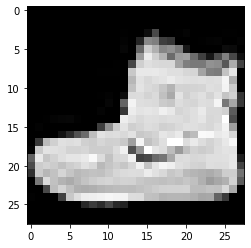

In [36]:
plt.imshow(x_train_all[0],cmap="gray")

In [37]:
x_train,x_val,y_train,y_val = train_test_split(x_train_all,y_train_all,stratify = y_train_all,test_size=0.2,random_state = 42)
x_train = x_train /255
x_val = x_val / 255
x_train = x_train.reshape(-1,784)
x_val = x_val.reshape(-1,784);

In [38]:
x_train.shape

(48000, 784)

In [39]:
# 원-핫 인코딩

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [49]:
fc = MultiClassNetwork(units = 100,batch_size=256)
fc.fit(x_train,y_train_encoded,x_val = x_val,y_val = y_val_encoded,epochs = 40)

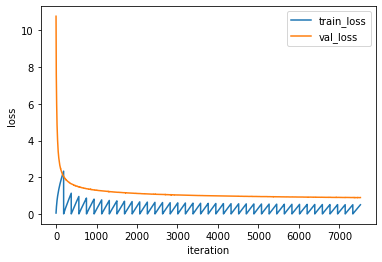

In [50]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel("loss")
plt.xlabel("iteration")
plt.legend(["train_loss","val_loss"])
plt.show()

In [51]:
fc.score(x_val,y_val_encoded)

0.8150833333333334